In [2]:
import urllib
import math
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.linear_model import LinearRegression
# change plot size
plt.rcParams['figure.dpi'] = 200

In [3]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_19-covid-Confirmed.csv","time_series_19-covid-Deaths.csv","time_series_19-covid-Recovered.csv"]
file = files[0]
link =URL+file
f = urllib.request.urlopen(link)
data = f.read()
f.close()
df = pd.read_csv(link)

In [25]:
# set row indices, only have dates for columns ids
data =df.set_index(["Country/Region","Lat","Long","Province/State"])

In [26]:
euro = ["Germany","France","Italy","Sweden","Switzerland","Spain","Portugal","Belgium","Iceland","Ireland"]
countries = {"NA":["US","Canada","Mexico"],
             "Asia":["South Korea","Taiwan","Japan"],
             "Middle East":["Iraq","Egypt","Iran"],"Euro":euro,
             "China":"Mainland China",
            "Italy":"Italy","South Korea":"South Korea","US":"US"}
noChin = data.index.levels[0][data.index.levels[0]!="Mainland China"]

4
0.05277218546689119
1.1292034216884865
4
-0.032868685501834825
0.9271101046165774


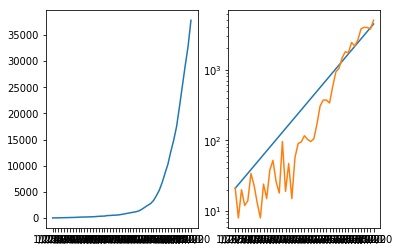

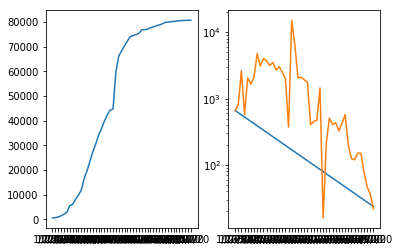

In [35]:
#assume (1+E*P) is 120%

#determine slope and plot
for name in [noChin,"Mainland China"]:
    plt.figure()
    vals= data.loc[name].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(lv[-1]-lv[0])/(sp.size(lv))

    print(m)
    print(math.pow(10,m))
    plt.subplot(1,2,2)
    plt.plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    plt.semilogy(vals)
    plt.subplot(1,2,1)
    plt.plot(data.loc[name].sum())
#print(vals.index)
#print(sp.size(lv))

#plt.plot()
#sp.size(vals)
#regressor.fit(vals.index.vals.values)
#vals.index[1].apply(toordinal)
#a = pd.to_datetime(vals.index)
#Xs = pd.to_datetime(vals.index).strftime("%Y%m%d").astype(int)


# Create linear regression object
#from sklearn import datasets, linear_model
#regr = linear_model.LinearRegression()
#regr.fit([Xs],[vals])
#regr.coef_

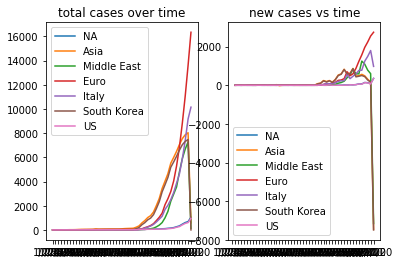

In [27]:

plt.subplot(1,2,1)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    plt.plot(data.loc[(country)].sum(),label=name)
plt.legend()
plt.title("total cases over time");

plt.subplot(1,2,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= data.loc[(country)].sum().diff()
    plt.plot(vals,label=name)
    

plt.legend()
plt.title("new cases vs time");